### IDs:
Insert yours IDs to the cell below

ID #1: 203972922

ID #2: 201312907

## Imports

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import seaborn as sns
from scipy.special import comb
from typing import Dict, Tuple
import warnings
import math
warnings.filterwarnings('ignore')

## functions

In [144]:
def convert_to_numeric(c):
    """
    hellper function for the pre-processing part
    """
    try:
        return pd.to_numeric(c)
    except:
        return c

def pre_processing_csv_file(csv_path):
    """
    read csv file, and preform pre-processing
    """
    first_actual_row = 59  # all previous rows are some irrelevant metadata
    df = pd.read_csv(csv_path, encoding='ISO-8859-1', header=None)
    temp_df = df.drop(df.index[:first_actual_row]).reset_index(drop=True)
    temp_df.dropna(how='any', axis=0)
    df = temp_df.T  # make patients as rows and [Class, IDs, and genes] as columns, for better readability
    column_names = df.iloc[0]  # get column names
    df = df[1:]  # don't include headers row in data
    df.columns = column_names
    df = df.apply(convert_to_numeric)
    df_dtypes = df.dtypes
    return df_dtypes, df

def generate_pair_box_plot():
    """
    Generated pair box plot to N gens
    each figure has 2 box plot, one for each class
    """
    BINS = 10
    N_genes = 2
    # starting from index 2 which is the first gene (0 is "Class" and 1 is "ID")
    random_indices = np.random.randint(low=2, high=df.shape[1], size=N_genes)
    for ax_ind, i in enumerate(random_indices):
        plt.figure()
        curr_columns = columns_list[i]
        ax1 = sns.boxplot(x="Class", y=curr_columns, data=df)
        ax1 = sns.swarmplot(x="Class", y=curr_columns, data=df, color=".25")

        gene_name = curr_columns
        ax1.set_title(f'Pair Boxplot of Gene: {gene_name}\n  **Myocardial Infraction** vs **Healthy** of patients')
    return

def calculate_RS_for_each_gene(g):
    """
    Calculate the RS sum
    """
    # get ranks of all samples for this gene g
    ranks = g.rank()
    # sum of the ranks of ONLY the 'M' samples for this gene g
    ranks_sums = ranks[M_samples].sum()
    return  ranks_sums

def calculate_t_test(g):
    """
    Calculate the T-test for the means of two 
    independent samples of scores
    """
    # this is the one Zohar mentioned in class
    return stats.ttest_ind(g[M_samples], g[H_samples], equal_var=True)

def calculate_WRS(g):
    """
    Calculate the WRS for two 
    independent samples of scores
    """
    return stats.ranksums(g[M_samples], g[H_samples])

def generate_RS_histogram(df):
    """
    generate for each gene RS value and generated histogram
    to those value, and calculate the IQR
    """
    
    # generate RS value for each gene
    ranked_df = df.iloc[:, 2:].apply(calculate_RS_for_each_gene, axis=0)
    ranked_df.hist(bins=30, density=True)
    # calculate precentile
    q75, q25 = np.percentile(ranked_df, [75, 25])
    # calculate IQR
    iqr = q75 - q25
    plt.title('histogram RS(g) vs samples labeled M')
    plt.ylabel('Density')
    plt.xlabel('RS(g)')
    max_y = plt.gca().get_ylim()[1]
    min_x = plt.gca().get_xlim()[0]
    plt.text(min_x * 1.05, max_y * 0.9, f'IQR: {iqr}', color='g', size=15, bbox=dict(facecolor='y', alpha=0.7))
    plt.show()
    
def gen_kendall_pairs(df):

    corrs: Dict[Tuple[str, str], 
                Tuple[np.float64, np.float64]] = dict()

    for gene1 in df.columns:
        for gene2 in df.columns:
            # avoiding correlations of a gene with itself
            if gene1 == gene2:
                continue

            key = (gene1, gene2)
            key_opposite = (gene2, gene1)
            # avoiding duplicates since tau(g1, g2) == tau(g2, g1)
            if key not in corrs and key_opposite not in corrs: 
                # return stats.kendalltau  --> tau, p-value
                kndl = stats.kendalltau(df[gene1], df[gene2])
                # update
                corrs[key] = (kndl[0], kndl[1]) 
    
    return corrs


def compute_fdr(pvals, fdr_th=0.05):
    """
    calculate FDR 
    """
    N = len(pvals) 

    report = None
    for i, pval in enumerate(np.sort(pvals)):
        gene_pairs = i + 1 # since i starts from 0

        fdr = (pval * N) / gene_pairs

        if report is None:
            report = gene_pairs

        if fdr <= fdr_th and gene_pairs > report:
            report = gene_pairs
    curr_string = 'We can report ' + str(report)+ ' in FDR = ' + str(fdr_th)
    print(curr_string)
    
    return report, fdr_th


def overabundance_graph(pvals, title):
    """
    generate FDR plot
    """
    plt.figure(figsize = (10, 8))
    pvals = pvals.copy()
    x_actual = np.sort(pvals)
    N = x_actual.shape[0]
    x_expected = np.linspace(0, 1.0, N)
    y = np.arange(N)
    plt.title(f"{title} - overabundance graph", fontsize=20)
    plt.xlabel("p-value(i)", fontsize=15)
    plt.ylabel("i", fontsize=15)
    plt.plot(x_actual, y, color='g', label='Actual distribution')
    plt.plot(x_expected, y, color='b', label='Expected distribution')
    plt.legend()
    plt.grid()
    
def plot_expression_patterns(g):
    """
    Plot differential expression (DE) values observed for each gene in H vs M
    """
    sns.kdeplot(g[M_samples], shade=True, label='M')
    sns.kdeplot(g[H_samples], shade=True, label='H')
    plt.title(g.name)
    plt.xlabel('Differential Expression')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()
    return 

### 2)The Data Set

In [31]:
"""
pre-processing data 
"""
csv_path = r"C:\Msc\Git\StatisticsAndDataAnalysis\hw4\AMI_GSE66360_series_matrix.csv"

df_dtypes, df = pre_processing_csv_file(csv_path)

## print data as DataFrame

In [32]:
df

0  Class      ID_REF  1007_s_at   1053_at    117_at    121_at  1255_g_at  \
1      H  GSM1620819   5.866378  8.225790  6.179732  6.179478   2.792048   
2      H  GSM1620820   4.948736  7.525865  6.628137  6.582889   2.695714   
3      H  GSM1620821   5.148384  7.764637  5.859151  6.602135   2.580181   
4      H  GSM1620822   5.064419  7.198461  5.974135  6.545905   2.712124   
5      H  GSM1620823   5.017833  7.831450  6.793079  5.911542   2.723687   
..   ...         ...        ...       ...       ...       ...        ...   
95     M  GSM1620913   6.472517  8.261422  6.367759  6.440978   3.730139   
96     M  GSM1620914   5.678816  6.925753  6.835756  6.955883   2.914868   
97     M  GSM1620915   5.653286  7.918424  7.577035  6.499215   3.013901   
98     M  GSM1620916   6.013841  7.442701  7.147417  6.587065   2.729320   
99     M  GSM1620917   5.465334  9.225221  6.481128  6.897591   3.151449   

0    1294_at   1316_at   1320_at  ...  AFFX-r2-Ec-bioD-3_at  \
1   9.290411  6.998285  5.348944  ...             13.257325   
2   9.462275  6.558215  5.410884  ...             13.593860   
3   9.116776  6.851623  5.254073  ...             13.372759   
4   9.134584  7.357827  5.242140  ...             13.490226   
5   9.582344  7.283873  5.219484  ...             13.236785   
..       ...       ...       ...  ...                   ...   
95  7.355730  6.206879  6.217930  ...              6.601746   
96  7.944295  6.638364  5.992344  ...             14.271037   
97  8.563123  7.379568  5.766029  ...             13.898616   
98  8.699222  6.598350  5.577456  ...             13.847006   
99  8.194374  6.133298  6.193797  ...             14.087965   

0   AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
1              13.266235            14.571230            14.276568   
2              13.517013            14.738834            14.341233   
3              13.416583            14.627181            14.318568   
4              13.494827            14.754124            14.363297   
5              13.330192            14.548389            14.263677   
..                   ...                  ...                  ...   
95              5.942308             7.290514             8.988511   
96             14.163706            14.884506            14.792506   
97             13.682425            14.884506            14.783801   
98             13.551593            14.858066            14.778166   
99             13.867425            14.882728            14.792506   

0   AFFX-ThrX-3_at  AFFX-ThrX-5_at  AFFX-ThrX-M_at  AFFX-TrpnX-3_at  \
1         4.504659        3.139334        2.747015         2.651554   
2         4.409226        3.039961        2.638606         2.643615   
3         4.310076        3.220109        2.495261         2.626028   
4         4.439311        3.263782        2.544199         2.504958   
5         4.562883        3.138524        2.506630         2.609707   
..             ...             ...             ...              ...   
95        5.567947        5.558780        5.429437         4.487940   
96        4.902195        3.416999        2.834741         2.782356   
97        5.239906        3.699181        3.249683         3.056727   
98        4.556134        3.485280        2.711413         2.833818   
99        5.573425        4.211922        3.346835         3.069542   

0   AFFX-TrpnX-5_at  AFFX-TrpnX-M_at  
1          3.413429         3.140612  
2          3.399063         3.132691  
3          3.539970         3.698396  
4          3.396225         3.638612  
5          3.434720         3.577649  
..              ...              ...  
95         4.254286         5.375811  
96         3.882080         3.744138  
97         3.649827         4.021536  
98         3.523410         3.812564  
99         4.108475         4.592122  

[99 rows x 54677 columns]

## print data types as functon of columns

In [33]:
df_dtypes

0
Class               object
ID_REF              object
1007_s_at          float64
1053_at            float64
117_at             float64
                    ...   
AFFX-ThrX-5_at     float64
AFFX-ThrX-M_at     float64
AFFX-TrpnX-3_at    float64
AFFX-TrpnX-5_at    float64
AFFX-TrpnX-M_at    float64
Length: 54677, dtype: object

#### 3. Analysis

## 3.a) 
High level description of the data and some pre-processing

In [34]:
"""
a.1 How many genes profiled
"""
# the amount of columns - the two first columns are Class & ID_REF
amount_of_columns = df.shape[1]
curr_string = 'The amount of genes profiled is ' + str(amount_of_columns-2)
print(curr_string)

The amount of genes profiled is 54675


In [35]:
"""
a.2 How many samples (subjects/patients) in total
"""

# the amount of rows - the two first columns are Class & ID_REF
amount_of_rows = df.shape[0]
initial_amount_of_columns = amount_of_columns
curr_string = 'The amount of samples (subjects/patients) in total is ' + str(amount_of_rows)
print(curr_string)

The amount of samples (subjects/patients) in total is 99


H    50
M    49
Name: Class, dtype: int64


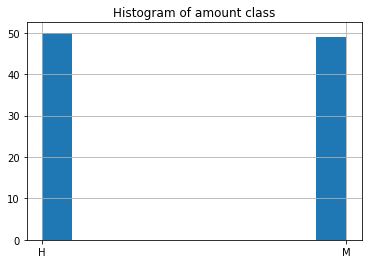

In [36]:
"""
a.3 How many samples in each class?
"""
hist = df['Class'].hist()
plt.title('Histogram of amount class')
count_df = df['Class'].value_counts()
print(count_df)

In [37]:
"""
a.4
If there are missing values, then remove the entire row
(gene) from the data matrix.
How many rows left now?
"""
# check if there is null\missing values in data frame

df.dropna(axis='columns', inplace=True) # Removing columns with missing values
amount_of_miss_rows = initial_amount_of_columns-df.shape[1]

amount_of_columns = df.shape[1]
columns_list = df.columns.to_list()
curr_string = 'The amount of removed columns is ' + str(amount_of_miss_rows) + \
            '\nThe amount of left columns is ' + str(amount_of_columns)
    
print(curr_string)


The amount of removed columns is 47
The amount of left columns is 54630


## print data as DataFrame after removing of columns

In [38]:
df

0  Class      ID_REF  1007_s_at   1053_at    117_at    121_at  1255_g_at  \
1      H  GSM1620819   5.866378  8.225790  6.179732  6.179478   2.792048   
2      H  GSM1620820   4.948736  7.525865  6.628137  6.582889   2.695714   
3      H  GSM1620821   5.148384  7.764637  5.859151  6.602135   2.580181   
4      H  GSM1620822   5.064419  7.198461  5.974135  6.545905   2.712124   
5      H  GSM1620823   5.017833  7.831450  6.793079  5.911542   2.723687   
..   ...         ...        ...       ...       ...       ...        ...   
95     M  GSM1620913   6.472517  8.261422  6.367759  6.440978   3.730139   
96     M  GSM1620914   5.678816  6.925753  6.835756  6.955883   2.914868   
97     M  GSM1620915   5.653286  7.918424  7.577035  6.499215   3.013901   
98     M  GSM1620916   6.013841  7.442701  7.147417  6.587065   2.729320   
99     M  GSM1620917   5.465334  9.225221  6.481128  6.897591   3.151449   

0    1294_at   1316_at   1320_at  ...  AFFX-r2-Ec-bioD-3_at  \
1   9.290411  6.998285  5.348944  ...             13.257325   
2   9.462275  6.558215  5.410884  ...             13.593860   
3   9.116776  6.851623  5.254073  ...             13.372759   
4   9.134584  7.357827  5.242140  ...             13.490226   
5   9.582344  7.283873  5.219484  ...             13.236785   
..       ...       ...       ...  ...                   ...   
95  7.355730  6.206879  6.217930  ...              6.601746   
96  7.944295  6.638364  5.992344  ...             14.271037   
97  8.563123  7.379568  5.766029  ...             13.898616   
98  8.699222  6.598350  5.577456  ...             13.847006   
99  8.194374  6.133298  6.193797  ...             14.087965   

0   AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
1              13.266235            14.571230            14.276568   
2              13.517013            14.738834            14.341233   
3              13.416583            14.627181            14.318568   
4              13.494827            14.754124            14.363297   
5              13.330192            14.548389            14.263677   
..                   ...                  ...                  ...   
95              5.942308             7.290514             8.988511   
96             14.163706            14.884506            14.792506   
97             13.682425            14.884506            14.783801   
98             13.551593            14.858066            14.778166   
99             13.867425            14.882728            14.792506   

0   AFFX-ThrX-3_at  AFFX-ThrX-5_at  AFFX-ThrX-M_at  AFFX-TrpnX-3_at  \
1         4.504659        3.139334        2.747015         2.651554   
2         4.409226        3.039961        2.638606         2.643615   
3         4.310076        3.220109        2.495261         2.626028   
4         4.439311        3.263782        2.544199         2.504958   
5         4.562883        3.138524        2.506630         2.609707   
..             ...             ...             ...              ...   
95        5.567947        5.558780        5.429437         4.487940   
96        4.902195        3.416999        2.834741         2.782356   
97        5.239906        3.699181        3.249683         3.056727   
98        4.556134        3.485280        2.711413         2.833818   
99        5.573425        4.211922        3.346835         3.069542   

0   AFFX-TrpnX-5_at  AFFX-TrpnX-M_at  
1          3.413429         3.140612  
2          3.399063         3.132691  
3          3.539970         3.698396  
4          3.396225         3.638612  
5          3.434720         3.577649  
..              ...              ...  
95         4.254286         5.375811  
96         3.882080         3.744138  
97         3.649827         4.021536  
98         3.523410         3.812564  
99         4.108475         4.592122  

[99 rows x 54630 columns]

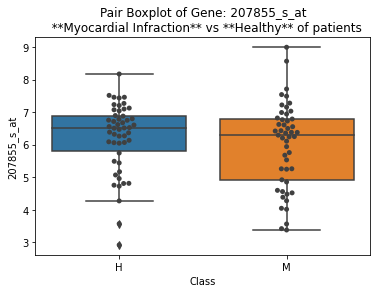

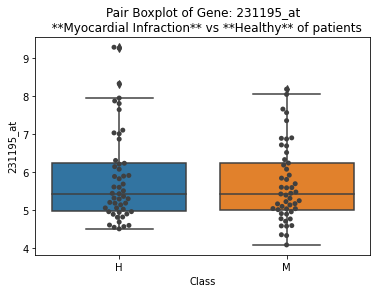

In [39]:
"""
a.5) 
Pick 20 genes at random. Draw 20 pair boxplots in one
figure comparing expression levels of each of these genes
in the two classes M and H.

!!!!!!!!!! need to increase to 20 !!!!!!!!!
"""
mask = df['Class'] == 'H'
df_H = df[mask]
df_M = df[~mask]

generate_pair_box_plot()

## b. 

## WRS for differential expression (DE)

In [42]:
"""
b.1 
Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE),
what is the expected sum of ranks of g’s expression levels measured for samples labeled M?
"""
H_samples = df.loc[df['Class'] == 'H']
M_samples = df.loc[df['Class'] == 'M']

H_samples_count, M_samples_count =  count_df.to_list()
B = H_samples_count + M_samples_count
excepted_mue_T = ((M_samples_count)*(B+1))/(2)
curr_string = 'The Excepted value is ' + str(excepted_mue_T)
print(curr_string)

The Excepted value is 2450.0


##### Answer:
* we know from our lecture that: <br>
$B =|M| +|H|$<br> 
$\mu_T = \frac{|M|(B+1)}{2}$

In [46]:
"""
2.b  
Denote this sum of ranks by RS(g). What is the maximal value, c,
that RS(g) can take?
"""

maximum_R_s = np.sum(np.arange(H_samples_count, B)+1)
curr_string = 'The Maximum RS value is ' + str(maximum_R_s)
print(curr_string)

The Maximum RS value is 3675


##### Answer:
* note that WRS is not care abount values because of the ranks
* therefore if the data of M,H are seprated, and farthere more the M are all
    smaller than the H values


In [48]:
"""
b.3 
Under the null model, what is the probability of RS(g) = c?
(Provide a formula for this and explain it)
"""
denominator = comb(B, M_samples_count, exact=True)
probability = 1 / denominator



## Answer:
* note that this is combination order problem, however there is only one option
    to order the value of M\H


##### Answer:
* P(A) = What is the probability that a specific example is in A
* $n(A)$ - is the number of option to order ellements from M class:
    * $n(A) = |M|!$
* $\Omega$ - total number of outcomes (the probability sample space)
    * B = |M|+|H|
    * Total number of options, $\Omega = {B \choose |M|} |M|!$
* $P(A) = \frac {n(A)}{\Omega}$ where $\Omega$!
* $$P\big(RS(g) = c\big) = \frac {|M|!}{{B \choose |M|} |M|!} = \frac {1}{{B \choose |M|}} = \frac {1}{{99 \choose 49}}$$


In [54]:
"""
Under the null model, what is the probability of RS(g) = c-1? what is
the probability of RS(g) = c-2?
(provide formulas and explain them)
"""

# first case 
denominator = comb(B, M_samples_count, exact=True)
probability_case1= math.factorial(1) / denominator
curr_string = 'The probability is case 1 is ' + str(probability_case1)
print(curr_string)
denominator = comb(B, M_samples_count, exact=True)
probability_case2= math.factorial(2) / denominator
curr_string = 'The probability is case 2 is ' + str(probability_case2)
print(curr_string)

The probability is case 1 is 1.9823306042836678e-29
The probability is case 2 is 3.9646612085673355e-29


$$P\big(RS(g) = c-1\big) = \frac {|M|!}{{B \choose |M|} |M|!} = \frac {1}{{B \choose |M|}} = \frac {1}{{99 \choose 49}}$$

* in the two cases the $\Omega$ is not changing
* we can look on this problem as the numinator is splited into two order problems
    * first we need to order the last |M| elements, and after to order the remian base the question
* genral equation will be:
$$P\big(RS(g) = c-j\big) = \frac {(j!)|M|!}{{B \choose |M|} |M|!} $$

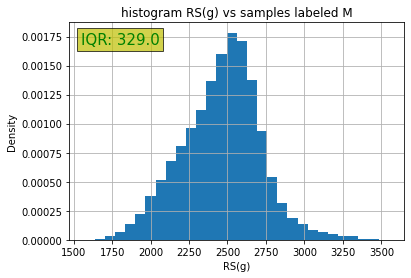

In [59]:
"""
b.5
Draw a histogram of the values of RS(g) in the dataset. Here g
ranges over all genes in the data (after the clean-up). Compute the
IQR for this distribution and present it on the plot with the histogram
"""

H_samples = df['Class'] == 'H'
M_samples = df['Class'] == 'M'
generate_RS_histogram(df)


c. Differential Expression
The purpose is to determine the statistical significance of
differential expression (DE) observed for each gene in H vs M.
Evaluate the DE in both one-sided directions for every gene,
using both Student t-test and WRS test.
Report the number of genes overexpressed in M vs H at a p-value
better (≤) than 0.07 and separately genes underexpressed in M
vs H at a p-value of 0.07. For both directions use both a Student ttest and a WRS test.

In [66]:
alpha = 0.07 # certainty of 93%

"""starting from index 2 which is the first gene
(0 is "Class" and 1 is "ID")
"""
# for each gene calulate t-test and p-value base this methood 
t_test_df = df.iloc[:,2:].apply(calculate_t_test, axis=0, result_type='expand')
t_test_df.index=['t_test', 'p-value']
t_test_df

0        1007_s_at   1053_at    117_at    121_at  1255_g_at  1294_at  \
t_test   -1.278585  0.447602  4.041393  0.102599   0.481005 -1.25881   
p-value   0.204094  0.655439  0.000106  0.918493   0.631596  0.21112   

0         1316_at   1320_at  1405_i_at   1431_at  ...  AFFX-r2-Ec-bioD-3_at  \
t_test  -2.885473  2.406316  -2.154836 -4.055713  ...             -0.616825   
p-value  0.004817  0.018008   0.033650  0.000101  ...              0.538795   

0        AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
t_test              -0.838321            -0.598171            -0.755246   
p-value              0.403911             0.551120             0.451931   

0        AFFX-ThrX-3_at  AFFX-ThrX-5_at  AFFX-ThrX-M_at  AFFX-TrpnX-3_at  \
t_test         2.221230        1.108412        0.961627         1.051736   
p-value        0.028661        0.270425        0.338628         0.295534   

0        AFFX-TrpnX-5_at  AFFX-TrpnX-M_at  
t_test          0.617371         1.471453  
p-value         0.538437         0.144406  

[2 rows x 54628 columns]

In [71]:
t_test_values = t_test_df.T['t_test'] # The calculated t-statistic
t_test_p_values = t_test_df.T['p-value'] / 2  # Since "ttest_ind()" returns the 2-tailed p-value of the test, we divide the values by 2 ("...a two-sided test for the null hypothesis")

t_test_overexpressed_genes_df = t_test_df.T[(t_test_values > 0) & (t_test_p_values <= alpha)]
t_test_underexpressed_genes_df = t_test_df.T[(t_test_values <= 0) & (t_test_p_values <= alpha)]

In [72]:
t_test_underexpressed_genes_df

t_test   p-value
0                                             
1316_at                    -2.885473  0.004817
1405_i_at                  -2.154836  0.033650
1431_at                    -4.055713  0.000101
1552277_a_at               -2.952385  0.003955
1552280_at                 -2.036412  0.044435
...                              ...       ...
65472_at                   -2.446916  0.016208
65585_at                   -3.430729  0.000886
81811_at                   -2.070764  0.041037
91617_at                   -2.033067  0.044778
AFFX-HUMISGF3A/M97935_3_at -1.967935  0.051931

[8639 rows x 2 columns]

In [73]:
t_test_overexpressed_genes_df

t_test   p-value
0                                      
117_at               4.041393  0.000106
1320_at              2.406316  0.018008
1552276_a_at         2.210267  0.029438
1552289_a_at         1.491806  0.138995
1552293_at           2.123148  0.036287
...                       ...       ...
AFFX-M27830_5_at     1.946407  0.054499
AFFX-M27830_M_at     1.822695  0.071430
AFFX-PheX-3_at       1.575338  0.118434
AFFX-r2-Bs-phe-3_at  2.557859  0.012080
AFFX-ThrX-3_at       2.221230  0.028661

[8517 rows x 2 columns]

In [74]:
"""
starting from index 2 which is the first gene 
(0 is "Class" and 1 is "ID")
"""
# for each gene calulate WRS and p-value base this methood 
WRS_df = df.iloc[:,2:].apply(calculate_WRS, axis=0, result_type='expand')
WRS_df.index=['WRS', 'p-value']
WRS_df

0        1007_s_at   1053_at    117_at    121_at  1255_g_at   1294_at  \
WRS      -1.021787  1.077775  4.290106  0.629869   1.035784 -1.679650   
p-value   0.306882  0.281134  0.000018  0.528780   0.300303  0.093025   

0         1316_at   1320_at  1405_i_at   1431_at  ...  AFFX-r2-Ec-bioD-3_at  \
WRS     -3.079359  1.686649  -2.918392 -3.681233  ...                   0.0   
p-value  0.002074  0.091671   0.003518  0.000232  ...                   1.0   

0        AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
WRS                 -0.153968             0.640367             0.804832   
p-value              0.877635             0.521934             0.420916   

0        AFFX-ThrX-3_at  AFFX-ThrX-5_at  AFFX-ThrX-M_at  AFFX-TrpnX-3_at  \
WRS            2.365507        2.281525        2.204541         1.574672   
p-value        0.018005        0.022517        0.027486         0.115332   

0        AFFX-TrpnX-5_at  AFFX-TrpnX-M_at  
WRS             1.469694         1.672652  
p-value         0.141645         0.094396  

[2 rows x 54628 columns]

In [76]:

WRS_df_copy = WRS_df.copy()

WRS_values = WRS_df_copy.T['WRS'] # The test statistic under the large-sample approximation that the rank sum statistic is normally distributed
WRS_p_values = WRS_df_copy.T['p-value'] / 2  # Since "ranksums()" returns the 2-sided p-value of the test, we divide the values by 2

WRS_overexpressed_genes_df = WRS_df_copy.T[(WRS_values > 0) & (WRS_p_values < alpha)]
WRS_underexpressed_genes_df = WRS_df_copy.T[(WRS_values <= 0) & (WRS_p_values < alpha)]


In [77]:
WRS_overexpressed_genes_df

WRS   p-value
0                                  
117_at           4.290106  0.000018
1320_at          1.686649  0.091671
1552271_at       1.784628  0.074322
1552276_a_at     2.351510  0.018697
1552279_a_at     1.728640  0.083874
...                   ...       ...
AFFX-ThrX-3_at   2.365507  0.018005
AFFX-ThrX-5_at   2.281525  0.022517
AFFX-ThrX-M_at   2.204541  0.027486
AFFX-TrpnX-3_at  1.574672  0.115332
AFFX-TrpnX-M_at  1.672652  0.094396

[10787 rows x 2 columns]

In [78]:
WRS_underexpressed_genes_df

WRS   p-value
0                                              
1294_at                     -1.679650  0.093025
1316_at                     -3.079359  0.002074
1405_i_at                   -2.918392  0.003518
1431_at                     -3.681233  0.000232
1552277_a_at                -2.547469  0.010851
...                               ...       ...
78383_at                    -1.616663  0.105951
81811_at                    -2.736430  0.006211
91617_at                    -2.183545  0.028996
AFFX-HUMISGF3A/M97935_3_at  -2.876401  0.004022
AFFX-HUMISGF3A/M97935_MB_at -1.833618  0.066711

[10667 rows x 2 columns]

## d. Correlations
Select the 80 most significant genes from each one of the onesided WRS DE lists you computed in 3c. Generate a set of 160
genes, D, which is the union of the above two sets.

In [83]:
"""
d.1
NOTE that the genes with smaller p values are more significant
we will choose the 80 most significant (smallest) genes from each one of the one-sided WRS DE 
"""
n = 80
over_significant_df = WRS_overexpressed_genes_df.sort_values(by='p-value').head(n) # sorting by the p-values
under_significant_df = WRS_underexpressed_genes_df.sort_values(by='p-value').head(n)

# Generate a set of 160 genes, D, which is the union of the above two sets
most_significant_df  = pd.concat([over_significant_df, under_significant_df])
most_significant_df = df[most_significant_df.index]

corrs = gen_kendall_pairs(most_significant_df)

D_kendall_correlations_df = most_significant_df.corr(method='kendall') 


In [85]:
plt.figure(figsize = (300,300))
sns.heatmap(D_kendall_correlations_df, annot=True,cmap="YlGnBu", vmin=-1, vmax=1)
plt.title('160 Most Significant Genes - Correlation', fontsize=20)
plt.xlabel('Gene name', fontsize=15)
plt.ylabel('Gene name', fontsize=15)
plt.show()


In [ ]:
"""
Compute Kendall tho correlations in all pairs within D (160
choose 2 numbers). Represent the correlation matrix as a 160x160
heatmap.
"""

In [88]:
# the excepted kendall value is the mean of all kendal values
kendall_mean = np.mean(D_kendall_correlations_df.mean())

curr_string = 'The kendall mean score is ' + str(kendall_mean)
print(curr_string)

The kendall mean score is 0.09016181231892703


answer:
* Under a NULL model that assumes that genes are pairwise independent\
* the expected value for 𝜏 would be 0
* For each pair of genes, their ranks will be randomly mixed and thus, on average
* we expect that the number of concordant pairs will eqaul the number of discordant pairs.<br>

In [98]:
"""
d.3
Now compute the Kendall tho correlations in all 80 choose 2 pairs
from the overexpressed genes in D. Present your results on a
histogram. What is the average value you observed?
Compare it to the value in the above section. Explain.
"""
n = 80
over_significant_df = WRS_overexpressed_genes_df.sort_values(by='p-value').head(n) # sorting by the p-values

# Generate a set of 160 genes, D, which is the union of the above two sets
most_overexpressed_genes_significant_df = df[over_significant_df.index]
corrs = gen_kendall_pairs(most_overexpressed_genes_significant_df)

D_kendall_most_overexpressed_genes_correlations_df = most_overexpressed_genes_significant_df.corr(method='kendall') 

In [102]:
D_kendall_most_overexpressed_genes_correlations_df

0            208869_s_at  216248_s_at  204622_x_at  244054_at  203888_at  \
0                                                                          
208869_s_at     1.000000     0.664399     0.617811   0.433519   0.408369   
216248_s_at     0.664399     1.000000     0.851165   0.448361   0.386931   
204622_x_at     0.617811     0.851165     1.000000   0.457019   0.392290   
244054_at       0.433519     0.448361     0.457019   1.000000   0.531231   
203888_at       0.408369     0.386931     0.392290   0.531231   1.000000   
...                  ...          ...          ...        ...        ...   
228648_at       0.313544     0.360544     0.355184   0.452896   0.480519   
243395_at       0.513915     0.494949     0.451659   0.401773   0.341991   
211628_x_at     0.423624     0.463203     0.465265   0.455782   0.442177   
203936_s_at     0.337868     0.394764     0.391053   0.476397   0.449598   
218319_at       0.552257     0.553906     0.534529   0.441765   0.338281   

0            203887_s_at  217202_s_at  203574_at  241279_at  240103_at  ...  \
0                                                                       ...   
208869_s_at     0.419913     0.475984   0.584003   0.489177   0.457019  ...   
216248_s_at     0.386106     0.466089   0.555968   0.484230   0.450423  ...   
204622_x_at     0.373325     0.442589   0.554731   0.450010   0.400536  ...   
244054_at       0.522160     0.534529   0.562564   0.460317   0.576582  ...   
203888_at       0.783137     0.492888   0.447537   0.448361   0.460730  ...   
...                  ...          ...        ...        ...        ...  ...   
228648_at       0.459905     0.406308   0.405483   0.428571   0.403834  ...   
243395_at       0.362606     0.482169   0.576170   0.511853   0.464028  ...   
211628_x_at     0.457844     0.522985   0.513090   0.463616   0.381159  ...   
203936_s_at     0.387755     0.463616   0.454545   0.480107   0.476809  ...   
218319_at       0.361369     0.449598   0.501546   0.346526   0.386931  ...   

0            209774_x_at  232213_at  204351_at  235568_at  200648_s_at  \
0                                                                        
208869_s_at     0.435993   0.607091   0.486704   0.360544     0.525046   
216248_s_at     0.414554   0.587302   0.434756   0.348176     0.466502   
204622_x_at     0.379509   0.550608   0.380746   0.371676     0.446300   
244054_at       0.506906   0.353948   0.447124   0.510616     0.496186   
203888_at       0.417440   0.315605   0.412905   0.570398     0.410843   
...                  ...        ...        ...        ...          ...   
228648_at       0.365492   0.238920   0.380746   0.476397     0.353948   
243395_at       0.494949   0.570398   0.512678   0.311482     0.528757   
211628_x_at     0.550608   0.446300   0.445475   0.494949     0.496186   
203936_s_at     0.406308   0.309421   0.431457   0.433107     0.382395   
218319_at       0.489590   0.576582   0.433107   0.332509     0.468975   

0            228648_at  243395_at  211628_x_at  203936_s_at  218319_at  
0                                                                       
208869_s_at   0.313544   0.513915     0.423624     0.337868   0.552257  
216248_s_at   0.360544   0.494949     0.463203     0.394764   0.553906  
204622_x_at   0.355184   0.451659     0.465265     0.391053   0.534529  
244054_at     0.452896   0.401773     0.455782     0.476397   0.441765  
203888_at     0.480519   0.341991     0.442177     0.449598   0.338281  
...                ...        ...          ...          ...        ...  
228648_at     1.000000   0.264482     0.374562     0.450423   0.195630  
243395_at     0.264482   1.000000     0.474335     0.382808   0.571635  
211628_x_at   0.374562   0.474335     1.000000     0.421975   0.512678  
203936_s_at   0.450423   0.382808     0.421975     1.000000   0.318079  
218319_at     0.195630   0.571635     0.512678     0.318079   1.000000  

[80 rows x 80 columns]

Text(0.5, 0, '# kendall score')

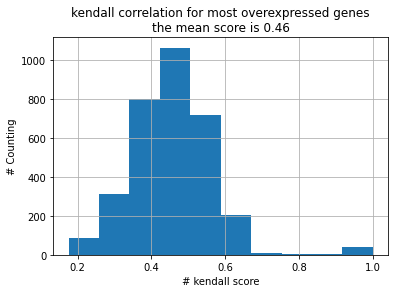

In [110]:
D_kendall_most_overexpressed_genes_correlations_df_array  = D_kendall_most_overexpressed_genes_correlations_df.to_numpy()
tho_list = np.fliplr(D_kendall_most_overexpressed_genes_correlations_df_array)[np.triu_indices(D_kendall_most_overexpressed_genes_correlations_df_array.shape[0])]
mean_kendal_score = np.round(np.mean(tho_list),2)
plt.hist(tho_list)
plt.grid()
plt.title('kendall correlation for most overexpressed genes\nthe mean score is ' + str(mean_kendal_score))
plt.ylabel('# Counting')
plt.xlabel('# kendall score')

In [ ]:
"""
d.4
What can you report about co-expression of genes in D (coexpression is inferred from the correlation of the expression
levels of genes, across a set of samples)?
"""

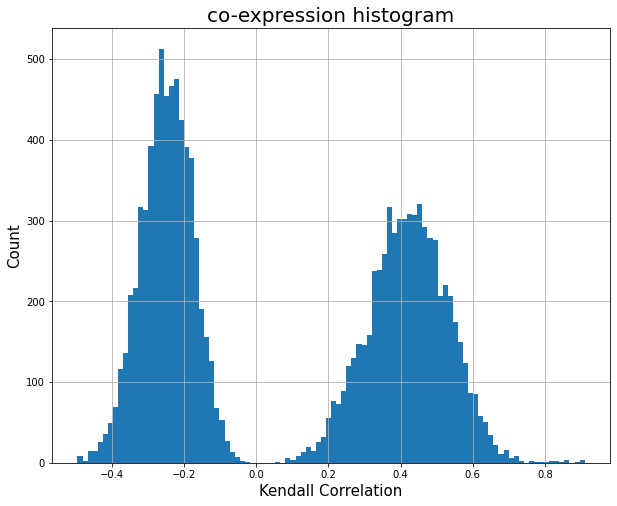

In [91]:
plt.figure(figsize = (10, 8))
plt.hist(np.array([v[0] for k, v in corrs.items()]), bins=100)
plt.title('co-expression histogram', fontsize=20)
plt.xlabel('Kendall Correlation', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid()
plt.show()

In [113]:

# a threshold that says "the correlation is a *strong* co-expression correlation if it's >= 0.5"
min_corr = 0.5 

co_expressed = np.array([v[0] for k, v in corrs.items() if v[0] > 0])
co_expressed_pairs = len(co_expressed)
significant_co_expression = np.sum(co_expressed >= min_corr)
print(f"We got {co_expressed_pairs} co-expressed pairs and {significant_co_expression} *strong* co-expressed pairs")

We got 3160 co-expressed pairs and 891 *strong* co-expressed pairs


* From the heatmap we can see that there is a strong positive co-expression among the overexpressed genes and also among the underexpressed genes.
* In the histogram these are probably in the right gaussian

- For overexpressed VS underexpressed 
    * we can see negative correlation. In the histogram these are in the left gaussian.
    * That makes sense. For instance, within overexpressed genes - we expect a relatively high amount of concordant pairs, since, when you look at a pair of (M, H) - you expect that M's expression levels will be higher than H's - so they will be concordant in terms of kendall.



* From our limited knowledge we tend to think that for (M, H) pairs we expect concordancy, and for (H, H) and (M, M) we expect less concordancy. <br>
* Actually, if that's the case - we indeed expect a positive correlation of ~0.5. <br>
    With a similar train of thought - the other results make sense (negative correlation between overepressed and underexpressed).

In [142]:
"""
d.5
What can you say about how many co-expressed pairs we
would observe (in the entire dataset) at FDR=0.05? Explain
your answer
"""
# taking p vals of only the positive correlared pairs
coexpressed_pvals = np.array([v[1] for k, v in corrs.items() if v[0] > 0])
compute_fdr(coexpressed_pvals)

We can report 3158 in FDR = 0.05


(3158, 0.05)

In [ ]:
"""
d.6
What would have been advantages and disadvantages of
computing co-expression for all genes in the study rather than
only for genes in D?
"""

* We believe the key point to answer this is to understand that it is possible to get a high correlation for 2 genes that are not especially over/under expressed. <br>
* However, doing this preprocessing of narrowing down to only the most over & under expressed genes - actually helps us to reach closer to a relationship of causation. This way we ensure higher chances that a biological truth will stand behind the correlation. <br>
## advantages&disadvantages of computing over all genes is the adventage of a brute-force approach 
*  For the advantages: 
    *  this way we can reveal all correlations, and potentially find interesting, strongly correlated pairs that are not necessairily in our over & under expressed samples, for 2 reasons 
    *  either they're not especially over/under expressed 
    * as we stated above, or because they're not in the top 80 of each group. Maybe in the top 100 for example.

* For the disadvantages:
    * mplexity - the number of pairs is in order of magnitude of |genes|^2 which is ~54000^2 =~ 3 Billion pairs
    * False Positives - as we explained above - the differential expression helps us to place a ground of biological truth behind the correlations.
    * For all pairs - with such high numbers we can get many high correlations, just by chance.

## e. Plots and Conclusions of the DE and correlation analysis


In [ ]:
"""
e.1
Construct the DE overabundance plots (blue and green lines
as shown in class) for M vs H overexpression (higher
expression levels in M) using WRS and t-test using the results
you had computed in Section 3c
State, for each comparison, the number of genes, k, at which
we observe:
a) FDR = 0.05
b) FDR = 0.01
c) FDR = 0.005
If these events are not observed at any k>0, then make that
statement
"""

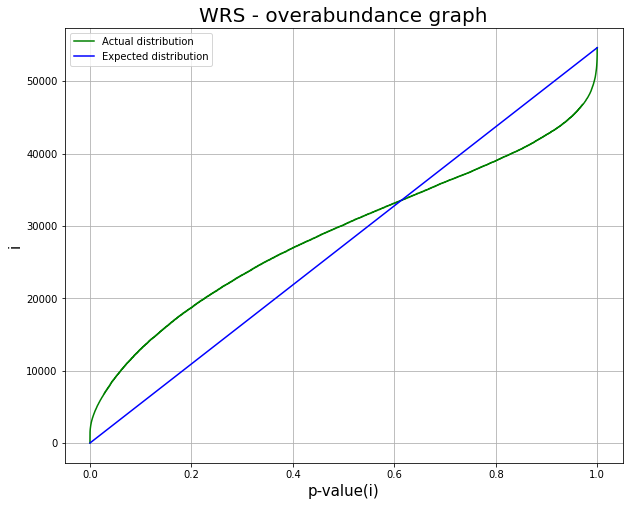

In [121]:
# a) FDR = 0.05
WRS_df_copy = WRS_df.copy()

# correct to one-sided pval
WRS_df_copy.loc['p-value'] = WRS_df_copy.loc['p-value'] / 2

# adjust to the wanted side of the statistic
opposite_side_mask = WRS_df_copy.loc['WRS'] < 0
WRS_df_copy.loc['p-value'][opposite_side_mask] = 1 - WRS_df_copy.loc['p-value'][opposite_side_mask]

overabundance_graph(pvals=WRS_df_copy.loc['p-value'], title='WRS')

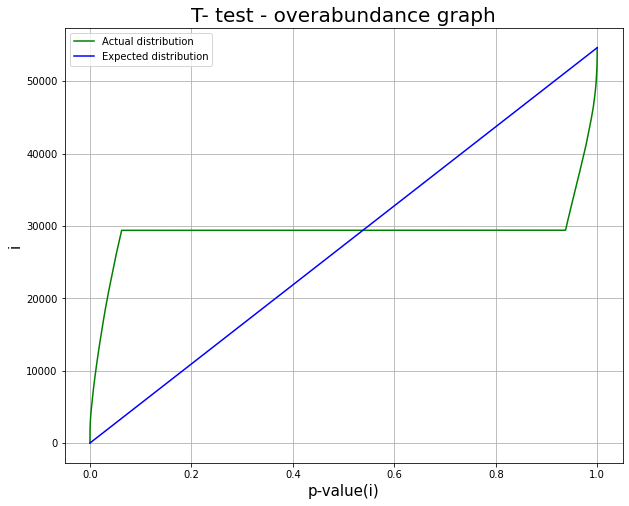

In [149]:
# b) FDR = 0.01
t_test_df_copy = t_test_df.copy()

# correct to one-sided pval
t_test_df.loc['p-value'] = t_test_df.loc['p-value'] / 2

# adjust to the wanted side of the statistic
opposite_side_mask = t_test_df.loc['t_test'] < 0
t_test_df_copy.loc['p-value'][opposite_side_mask] = 1 - t_test_df_copy.loc['p-value'][opposite_side_mask]

overabundance_graph(pvals=t_test_df_copy.loc['p-value'], title='T- test')

In [138]:
result_list = []
for pvals, desc in [(t_test_df_copy.loc['p-value'], 'T-test'), (WRS_df_copy.loc['p-value'], 'WRS')]:
    data_frame_value_list = []
    print('---------')
    print(desc)
    for fdr in [0.05, 0.01, 0.005]:
        curr_report, curr_fdr = compute_fdr(pvals, fdr_th=fdr)
        data_frame_value_list.append([curr_report, curr_fdr])
    score_df  = pd.DataFrame(data_frame_value_list, columns = ['report', 'fdr score'])
    result_list.append(score_df)
    print('---------')


---------
T-test
We can report 4038 in FDR = 0.05
We can report 1929 in FDR = 0.01
We can report 1563 in FDR = 0.005
---------
---------
WRS
We can report 2808 in FDR = 0.05
We can report 1601 in FDR = 0.01
We can report 1323 in FDR = 0.005
---------


In [134]:
T_test_result = result_list[0]
T_test_result

report  fdr score
0    4038      0.050
1    1929      0.010
2    1563      0.005

In [136]:
WRS_results = result_list[1]
WRS_results

report  fdr score
0    2808      0.050
1    1601      0.010
2    1323      0.005

In [141]:
"""
e.2
Select any 3 differentially expressed genes, from D (which
was defined in 3d), and produce a graphical representation of
their expression patterns that demonstrates the observed DE.
"""
most_significant_df  = pd.concat([over_significant_df, under_significant_df])

D_new = most_significant_df.sample(n=3)
D_new = df[D_new.index]
D_new.head()



0  204620_s_at  210845_s_at  1552321_a_at
1     7.778184     7.968373      9.758715
2     8.848254     7.483243      9.553356
3     4.919507     6.074515      9.580803
4     5.084573     5.742121      9.957972
5     7.452188     7.214327      9.439143

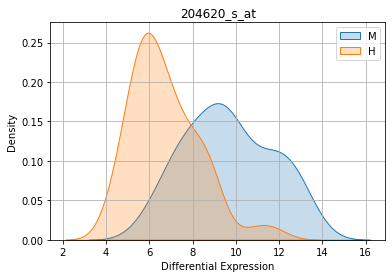

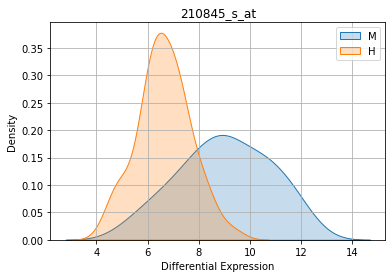

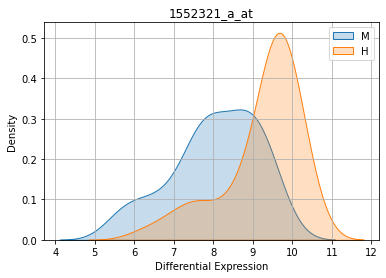

0
204620_s_at     None
210845_s_at     None
1552321_a_at    None
dtype: object

In [146]:
D_new.apply(plot_expression_patterns, axis=0)

Text(68.09375, 0.5, 'Genes')

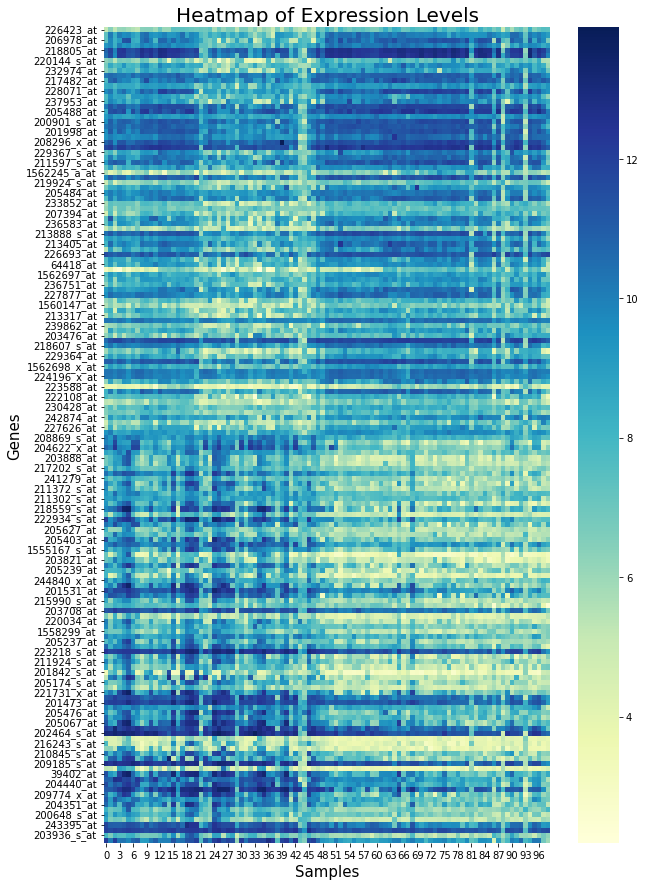

In [148]:
"""
e.3
Heatmap
Draw a heatmap representation of the expression values of
the genes in D (from 3d), across the entire cohort (all
samples). Order the genes and the samples to produce the
maximal visual effect.
"""
over = df[over_significant_df.index]
under = df[under_significant_df.index]

H_over = over.T[df[df['Class'] == 'H'].index]
H_under = under.T[df[df['Class'] == 'H'].index]

M_over = over.T[df[df['Class'] == 'M'].index]
M_under = under.T[df[df['Class'] == 'M'].index]

upper_genes = pd.concat([M_under, H_under], axis=1, ignore_index=True)
lower_genes = pd.concat([M_over, H_over], axis=1, ignore_index=True)
all_genes = pd.concat([upper_genes, lower_genes])

plt.figure(figsize = (10, 15))
sns.heatmap(all_genes, cmap="YlGnBu")
plt.title('Heatmap of Expression Levels', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Genes', fontsize=15)